In [2]:
import os
import socket
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import types as T, functions as F, SparkSession
from pyspark.sql.window import Window
from pyspark import StorageLevel
from jinja2 import Environment, FileSystemLoader
import datetime
import json
from pyspark.sql.functions import when

In [152]:
!hdfs dfs -cat /home/ljamschikova-362109/processed/part-00000-01077320-edf8-46d1-bf57-8a4d0f282a15-c000.json | head -n 3

cat: Permission denied: user=irubin-370046, access=EXECUTE, inode="/home/ljamschikova-362109/processed/part-00000-01077320-edf8-46d1-bf57-8a4d0f282a15-c000.json":ljamschikova-362109:ljamschikova-362109:drwx------


In [3]:
LOGIN = "irubin-370046"  # Your gateway.st login
APP_NAME = "ML"  # Any name for your Spark-app

In [4]:
NORMALIZED_APP_NAME = APP_NAME.replace('/', '_').replace(':', '_').replace(' ', '_').replace('\\', '_')

APPS_TMP_DIR = os.path.join(os.getcwd(), "tmp")
APPS_CONF_DIR = os.path.join(os.getcwd(), "conf")
APPS_LOGS_DIR = os.path.join(os.getcwd(), "logs")
LOG4J_PROP_FILE = os.path.join(APPS_CONF_DIR, "pyspark-log4j-{}.properties".format(NORMALIZED_APP_NAME))
LOG_FILE = os.path.join(APPS_LOGS_DIR, 'pyspark-{}.log'.format(NORMALIZED_APP_NAME))
EXTRA_JAVA_OPTIONS = (
    "-Dlog4j.configuration=file://{} "
    "-Dspark.hadoop.dfs.replication=1 "
    "-Dhttps.protocols=TLSv1.0,TLSv1.1,TLSv1.2,TLSv1.3"
    .format(LOG4J_PROP_FILE)
)

LOCAL_IP = socket.gethostbyname(socket.gethostname())

In [5]:
for directory in [APPS_CONF_DIR, APPS_LOGS_DIR, APPS_TMP_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

env = Environment(loader=FileSystemLoader('/opt'))
template = env.get_template("pyspark_log4j.properties.template")
template.stream(logfile=LOG_FILE).dump(LOG4J_PROP_FILE)

In [6]:
spark = (
    SparkSession
    .builder
    .appName(APP_NAME)
    
    # Master URI/configuration
    .master("k8s://https://10.32.7.103:6443")
    
    .config("spark.driver.host", LOCAL_IP)
    
    # Web-UI port for your Spark-app
    .config("spark.ui.port", "4040")
    .config("spark.driver.bindAddress", "0.0.0.0")
    
    # How many CPU cores allocate to driver process
    .config("spark.driver.cores", "2")
    
    # How many RAM allocate to driver process
    .config("spark.driver.memory", "6g")
    
    # How many executors to create
    .config("spark.executor.instances", "3")
    
    # How many CPU cores allocate to each executor
    .config("spark.executor.cores", '2')
    
    # How many RAM allocate to each executor
    .config("spark.executor.memory", "6g")
    
    # How many extra RAM allocate to each executor pod to handle with JVM overheads
    # Total pod RAM = 'spark.executor.memory' + ('spark.executor.memory' * 'spark.kubernetes.memoryOverheadFactor')
    .config("spark.kubernetes.memoryOverheadFactor", "0.2")
    
    # How many RAM from the pool allocate to store the data
    # Additional info: https://spark.apache.org/docs/latest/tuning.html#memory-management-overview
    .config("spark.memory.fraction", "0.6")
    .config("spark.memory.storageFraction", "0.5")
    
    .config("spark.network.timeout", "180s")
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")
    .config("spark.driver.extraJavaOptions", EXTRA_JAVA_OPTIONS)
    
    # Namespace to create executor pods. You are allowed to create pods only in your own namespace
    .config("spark.kubernetes.namespace", LOGIN)
    
    # Extra labels to your driver/executor pods in Kubernetes
    .config("spark.kubernetes.driver.label.appname", APP_NAME)
    .config("spark.kubernetes.executor.label.appname", APP_NAME)
    
    # Spark executor image
    .config("spark.kubernetes.container.image", f"node03.st:5000/spark-executor:{LOGIN}")

    .config("spark.kubernetes.container.image.pullPolicy", "Always")
    
    # If true - delete completed/failed pods. 
    # If your executors goes down you can set 'false' to check logs and troubleshoot your app.
    .config("spark.kubernetes.executor.deleteOnTermination", "true")
    
    .config("spark.local.dir", "/tmp/spark")
    .getOrCreate()
)

In [150]:
spark.stop()


In [7]:
DATA_PATH = "hdfs:///home/irubin-370046"

In [8]:
df = spark.read.json(f"{DATA_PATH}/final_df.json")

In [9]:
df = df.withColumn("Year", \
              when(df.Year == 2007, 1)\
                  .when(df.Year == 2008, 2)\
                  .when(df.Year == 2009, 3)\
                  .when(df.Year == 2010, 4)\
                 .when(df.Year == 2011, 5)\
                  .when(df.Year == 2012, 6)\
                  .when(df.Year == 2013, 7)\
                  .when(df.Year == 2014, 8)\
                  .when(df.Year == 2015, 9)\
                .when(df.Year == 2016, 10)\
                  .when(df.Year == 2017, 11)\
                  .when(df.Year == 2018, 12)\
                  .when(df.Year == 2019, 13)\
                  .when(df.Year == 2020, 14)\
                  .when(df.Year == 2021, 15)\
                  .when(df.Year == 2022, 16)\
                  .when(df.Year == 2023, 17)\
                   .when(df.Year == 2006, 0)\
                   .otherwise(df.Year)
                  )

In [10]:
from pyspark.sql.types import LongType
df = df.withColumn("Year", df["Year"].cast(LongType()))

In [11]:
df.printSchema()

root
 |-- Month: long (nullable = true)
 |-- Year: long (nullable = true)
 |-- caption: boolean (nullable = true)
 |-- categoryId: long (nullable = true)
 |-- dayofweek: long (nullable = true)
 |-- definition: string (nullable = true)
 |-- description_has_links: boolean (nullable = true)
 |-- description_has_tags: boolean (nullable = true)
 |-- description_len: double (nullable = true)
 |-- emoji_in_title: boolean (nullable = true)
 |-- has_description: boolean (nullable = true)
 |-- has_pop_tags: boolean (nullable = true)
 |-- has_tags: boolean (nullable = true)
 |-- hour: long (nullable = true)
 |-- licensedContent: boolean (nullable = true)
 |-- log_duration: double (nullable = true)
 |-- mean_popularity: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- status: boolean (nullable = true)
 |-- title_has_excl: boolean (nullable = true)
 |-- title_has_tags: boolean (nullable = true)
 |-- title_is_uppercase: boolean (nullable = true)
 |-- title_len: long (nullable 

In [11]:
df.columns

['Month',
 'Year',
 'caption',
 'categoryId',
 'dayofweek',
 'definition',
 'description_has_links',
 'description_has_tags',
 'description_len',
 'emoji_in_title',
 'has_description',
 'has_pop_tags',
 'has_tags',
 'hour',
 'licensedContent',
 'log_duration',
 'mean_popularity',
 'popularity',
 'status',
 'title_has_excl',
 'title_has_tags',
 'title_is_uppercase',
 'title_len']

In [12]:
# This features need one-hot encoding
need_ohe = ['dayofweek', 'categoryId', 'Year']

# This features need mapping from True/False values to 0/1 (just cast integer)
need_map = ['caption', 
            'description_has_links', 
            'description_has_tags',
            'emoji_in_title',
            'has_description',
            'has_pop_tags',
            'has_tags',
            'licensedContent',
            'status',
            'title_has_excl',
            'title_has_tags',
            'title_is_uppercase']

# Definition only has two values (hd, sd) and can be encoded as 0/1
need_map_too = ['definition']

# Need MinMax scaling
need_scaling = ['description_len', 'log_duration', 'mean_popularity', 'title_len', 'Month', 'hour']

In [13]:
df.count()

3438557

In [14]:
for col in need_map:
    df = (df.withColumn(col, df.licensedContent.cast('integer')))

In [15]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

unlist = udf(lambda x: float(list(x)[0]), DoubleType())

for i in need_scaling:
    assembler = VectorAssembler(inputCols=[i], outputCol=i+"_Vect")

    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    pipeline = Pipeline(stages=[assembler, scaler])

    df = pipeline.fit(df).transform(df).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

In [16]:
from pyspark.ml.feature import StringIndexer
str_indexer = StringIndexer(inputCol="definition", outputCol="definition_index")

str_indexer = str_indexer.fit(df)

df = str_indexer.transform(df)

In [17]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCols=need_ohe, 
                                 outputCols= [f'{col}_ohe' for col in need_ohe])
encoder = encoder.fit(df)

df = encoder.transform(df)

In [18]:
df.columns

['Month',
 'Year',
 'caption',
 'categoryId',
 'dayofweek',
 'definition',
 'description_has_links',
 'description_has_tags',
 'description_len',
 'emoji_in_title',
 'has_description',
 'has_pop_tags',
 'has_tags',
 'hour',
 'licensedContent',
 'log_duration',
 'mean_popularity',
 'popularity',
 'status',
 'title_has_excl',
 'title_has_tags',
 'title_is_uppercase',
 'title_len',
 'description_len_Scaled',
 'log_duration_Scaled',
 'mean_popularity_Scaled',
 'title_len_Scaled',
 'Month_Scaled',
 'hour_Scaled',
 'definition_index',
 'dayofweek_ohe',
 'categoryId_ohe',
 'Year_ohe']

https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a

In [19]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = [  'caption',
                                                 'description_has_links',
                                                 'description_has_tags',
                                                 'description_len',
                                                 'emoji_in_title',
                                                 'has_description',
                                                 'has_pop_tags',
                                                 'has_tags',
                                                 'licensedContent',
                                                 'status',
                                                 'title_has_excl',
                                                 'title_has_tags',
                                                 'title_is_uppercase',
                                                 'title_len',
                                                 'description_len_Scaled',
                                                 'log_duration_Scaled',
                                                 'mean_popularity_Scaled',
                                                 'title_len_Scaled',
                                                 'Month_Scaled',
                                                 'hour_Scaled',
                                                 'definition_index',
                                                 'dayofweek_ohe',
                                                 'categoryId_ohe',
                                                 'Year_ohe'], outputCol = 'features')
v_df = vectorAssembler.transform(df)
v_df = v_df.select(['features', 'popularity'])
v_df.show(3)

+--------------------+------------------+
|            features|        popularity|
+--------------------+------------------+
|(74,[0,1,2,3,4,5,...|1.5665938388561083|
|(74,[0,1,2,3,4,5,...|1.2711286086456879|
|(74,[0,1,2,3,4,5,...|1.4217195964321903|
+--------------------+------------------+
only showing top 3 rows



In [20]:
train, test = v_df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 2406736
Test Dataset Count: 1031821


## Linear regression

In [20]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import RegressionEvaluator

In [21]:
from pyspark.ml.regression import LinearRegression
lin_reg = LinearRegression(
    featuresCol='features', 
    labelCol='popularity') 

In [22]:
grid_search = ParamGridBuilder() \
    .addGrid(lin_reg.regParam, [0.0, 0.01, 0.1]) \
    .addGrid(lin_reg.elasticNetParam, [0.5, 1.0]) \
    .build()

In [23]:
evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol='popularity')

In [24]:
cv = CrossValidator(estimator=lin_reg,
                    estimatorParamMaps=grid_search,
                    evaluator=evaluator)
cv_model = cv.fit(train)

In [25]:
cv_model.bestModel.summary.meanAbsoluteError

0.1370620821191921

In [26]:
cv_model.bestModel.extractParamMap()

{Param(parent='LinearRegression_01652c9ac0f0', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_01652c9ac0f0', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0,
 Param(parent='LinearRegression_01652c9ac0f0', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35,
 Param(parent='LinearRegression_01652c9ac0f0', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LinearRegression_01652c9ac0f0', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_01652c9ac0f0', name='labelCol', doc='label column name.'): 'popularity',
 Param(parent='LinearRegression_01652c9ac0f0', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber.'): 'squared

In [27]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='popularity', maxIter=100, regParam=0.0, elasticNetParam=1)
lr_model = lr.fit(train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.00039051675972209636,0.00039051675972209636,0.00039051675972209636,0.002988712426235775,0.00039051675972209636,0.00039051675972209636,0.00039051675972209636,0.00039051675972209636,0.00039051675972209636,0.00039051675972209636,0.00039051675972209636,0.00039051675972209636,0.00039051675972209636,4.2204057216330175e-06,0.025461412562954772,0.1342673378723564,2.69131666882903,0.0005655343469054423,-0.006032037406587086,0.010939596869084354,-0.016924435096683895,0.0,-0.00045658633805622053,-0.009696723072582129,-0.012524761550644487,-0.011793799705893341,-0.010850319540416585,-0.009203955317511715,0.0,0.006927442787791366,0.01652170043299533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005724818459151594,0.0,0.0,0.0,0.0,0.02780177136449238,0.0,0.01125341755627125,0.0,0.012102513520203872,0.005008828024169174,0.0,0.015058730970933805,0.030257606940224068,0.012868033101913732,0.012432776796725564,0.01032196896183918,0.002962485518541356,0.008202725257327358,-0.12582966696171738,0.0225511068

In [28]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.189107
r2: 0.835329


In [29]:
lr_predictions = lr_model.transform(test)
lr_predictions.select("prediction","popularity","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="popularity",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------------------+--------------------+
|        prediction|        popularity|            features|
+------------------+------------------+--------------------+
|1.3988938704153688| 1.497020565062332|(74,[0,1,2,3,4,5,...|
| 1.830650116566798|1.8242777167343642|(74,[0,1,2,3,4,5,...|
|0.5212362020509632|0.5707814054862881|(74,[0,1,2,3,4,5,...|
| 0.935946094509648|0.9287076265649461|(74,[0,1,2,3,4,5,...|
|0.5056723227505078|0.4561038589454073|(74,[0,1,2,3,4,5,...|
+------------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.834815


In [30]:
test_result = lr_model.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 0.188958


## Decision Tree (нектуально)

In [121]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'popularity')
dt_model = dt.fit(train)


In [122]:
dt_predictions = dt_model.transform(test)
dt_evaluator = RegressionEvaluator(
    labelCol="popularity", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.191538


In [123]:
train.take(1)

[Row(features=SparseVector(75, {0: 1.0, 1: 29.0, 2: 1.0, 3: 1.0, 4: 4.2905, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 43.0, 15: 0.5036, 16: 0.5567, 17: 0.492, 18: 0.3134, 19: 0.2727, 20: 0.5652}), popularity=1.302050763547096)]

In [124]:
dt_model.featureImportances

SparseVector(75, {16: 0.0013, 17: 0.9984, 39: 0.0003, 53: 0.0001})

In [125]:
df.take(1)

[Row(Month=5, Year=15, caption=1, categoryId=22, dayofweek=7, definition='hd', description_has_links=1, description_has_tags=1, description_len=5.746203190540153, emoji_in_title=1, has_description=1, has_pop_tags=1, has_tags=1, hour=12, licensedContent=1, log_duration=6.037870919922137, mean_popularity=0.8351828330143496, popularity=1.5665938388561083, status=1, title_has_excl=1, title_has_tags=1, title_is_uppercase=1, title_len=68, description_len_Scaled=0.6745010247608874, log_duration_Scaled=0.5311949979140159, mean_popularity_Scaled=0.3000526524872972, title_len_Scaled=0.5, Month_Scaled=0.36363636363636365, hour_Scaled=0.5217391304347826, definition_index=0.0, dayofweek_ohe=SparseVector(7, {}), categoryId_ohe=SparseVector(29, {22: 1.0}), Year_ohe=SparseVector(17, {15: 1.0}))]

## GB tree regressor

In [25]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'popularity')

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 4, 5, 10])\
    .build()

evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol='popularity')

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train)
cvModel.avgMetrics




# trainingSummary = gbt_model.summary
# print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
# print("r2: %f" % trainingSummary.r2)


[0.192733511301617,
 0.18991497635568994,
 0.18820743174875615,
 0.18463744356289172]

In [26]:
cvModel.bestModel.extractParamMap()

{Param(parent='GBTRegressor_dfe5ae523c35', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTRegressor_dfe5ae523c35', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTRegressor_dfe5ae523c35', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regr

In [27]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'popularity', maxDepth=10, maxIter=100)

gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)
gbt_predictions.select('prediction', 'popularity', 'features').show(5)


+-------------------+------------------+--------------------+
|         prediction|        popularity|            features|
+-------------------+------------------+--------------------+
| 1.4211967852955594| 1.497020565062332|(74,[0,1,2,3,4,5,...|
| 1.7406523665392024|1.8242777167343642|(74,[0,1,2,3,4,5,...|
| 0.5343367312488532|0.5707814054862881|(74,[0,1,2,3,4,5,...|
| 0.8911101185913027|0.9287076265649461|(74,[0,1,2,3,4,5,...|
|0.48825065325240263|0.4561038589454073|(74,[0,1,2,3,4,5,...|
+-------------------+------------------+--------------------+
only showing top 5 rows



In [28]:
gbt_evaluator = RegressionEvaluator(
    labelCol="popularity", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.179347


In [1]:
gbt_model.featureImportances

NameError: name 'gbt_model' is not defined

In [30]:
gbt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="popularity",metricName="r2")
print("R Squared (R2) on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))

R Squared (R2) on test data = 0.851191


In [ ]:
################################################

In [12]:
# This features need one-hot encoding


# This features need mapping from True/False values to 0/1 (just cast integer)
need_map = ['caption', 
            'description_has_links', 
            'description_has_tags',
            'emoji_in_title',
            'has_description',
            'has_pop_tags',
            'has_tags',
            'licensedContent',
            'status',
            'title_has_excl',
            'title_has_tags',
            'title_is_uppercase']

# Definition only has two values (hd, sd) and can be encoded as 0/1
need_map_too = ['definition']

# Need MinMax scaling
need_scaling = ['description_len', 'log_duration', 'mean_popularity', 'title_len', 'Month', 'hour','dayofweek', 'categoryId', 'Year']

In [13]:
for col in need_map:
    df = (df.withColumn(col, df.licensedContent.cast('integer')))

In [14]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

unlist = udf(lambda x: float(list(x)[0]), DoubleType())

for i in need_scaling:
    assembler = VectorAssembler(inputCols=[i], outputCol=i+"_Vect")

    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    pipeline = Pipeline(stages=[assembler, scaler])

    df = pipeline.fit(df).transform(df).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

In [15]:
from pyspark.ml.feature import StringIndexer
str_indexer = StringIndexer(inputCol="definition", outputCol="definition_index")

str_indexer = str_indexer.fit(df)

df = str_indexer.transform(df)

In [16]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = [  'caption',
                                                 'description_has_links',
                                                 'description_has_tags',
                                                 'description_len',
                                                 'emoji_in_title',
                                                 'has_description',
                                                 'has_pop_tags',
                                                 'has_tags',
                                                 'licensedContent',
                                                 'status',
                                                 'title_has_excl',
                                                 'title_has_tags',
                                                 'title_is_uppercase',
                                                 'title_len',
                                                 'description_len_Scaled',
                                                 'log_duration_Scaled',
                                                 'mean_popularity_Scaled',
                                                 'title_len_Scaled',
                                                 'Month_Scaled',
                                                 'hour_Scaled',
                                                 'definition_index',
                                                 'dayofweek_Scaled',
                                                 'categoryId_Scaled',
                                                 'Year_Scaled'], outputCol = 'features')
v_df = vectorAssembler.transform(df)
v_df = v_df.select(['features', 'popularity'])
v_df.show(3)

+--------------------+------------------+
|            features|        popularity|
+--------------------+------------------+
|[1.0,1.0,1.0,5.74...|1.5665938388561083|
|[1.0,1.0,1.0,5.37...|1.2711286086456879|
|[1.0,1.0,1.0,6.96...|1.4217195964321903|
+--------------------+------------------+
only showing top 3 rows



In [17]:
train, test = v_df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 2406736
Test Dataset Count: 1031821


In [18]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'popularity', maxDepth=10, maxIter=100)

gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)
gbt_predictions.select('prediction', 'popularity', 'features').show(5)

+-------------------+-------------------+--------------------+
|         prediction|         popularity|            features|
+-------------------+-------------------+--------------------+
|  0.564711071906679| 0.6981107644785808|(24,[3,13,14,15,1...|
| 0.1156631106093496|0.09879839543056498|(24,[3,13,14,15,1...|
|0.21929804048176724| 0.3265858313135614|(24,[3,13,14,15,1...|
|0.22283150385607967| 0.3174995691591199|(24,[3,13,14,15,1...|
|0.14172290930341314|0.11866544380791419|(24,[3,13,14,15,1...|
+-------------------+-------------------+--------------------+
only showing top 5 rows



In [21]:
gbt_evaluator = RegressionEvaluator(
    labelCol="popularity", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.178937


In [22]:
gbt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="popularity",metricName="r2")
print("R Squared (R2) on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))

R Squared (R2) on test data = 0.852384


In [31]:
cols = [   'caption',
                                                 'description_has_links',
                                                 'description_has_tags',
                                                 'description_len',
                                                 'emoji_in_title',
                                                 'has_description',
                                                 'has_pop_tags',
                                                 'has_tags',
                                                 'licensedContent',
                                                 'status',
                                                 'title_has_excl',
                                                 'title_has_tags',
                                                 'title_is_uppercase',
                                                 'title_len',
                                                 'description_len',
                                                 'log_duration',
                                                 'mean_popularity',
                                                 'title_len',
                                                 'Month',
                                                 'hour',
                                                 'definition_index',
                                                 'dayofweek',
                                                 'categoryId',
                                                 'Year']


In [33]:
featureImp= gbt_model.featureImportances

In [34]:
x=featureImp.toArray()

In [35]:
def add_element(dict, key, value):
    if key not in dict:
        dict[key] = []
    dict[key].append(value)

In [36]:
sloavr={}
for i in range(0,len(cols)):
    e=x[i].item()
    sloavr[cols[i]] = e
    

In [37]:
z= {x:y for x,y in sloavr.items() if y!=0}

In [38]:
z=dict(sorted(z.items(), key=lambda item: item[1]))

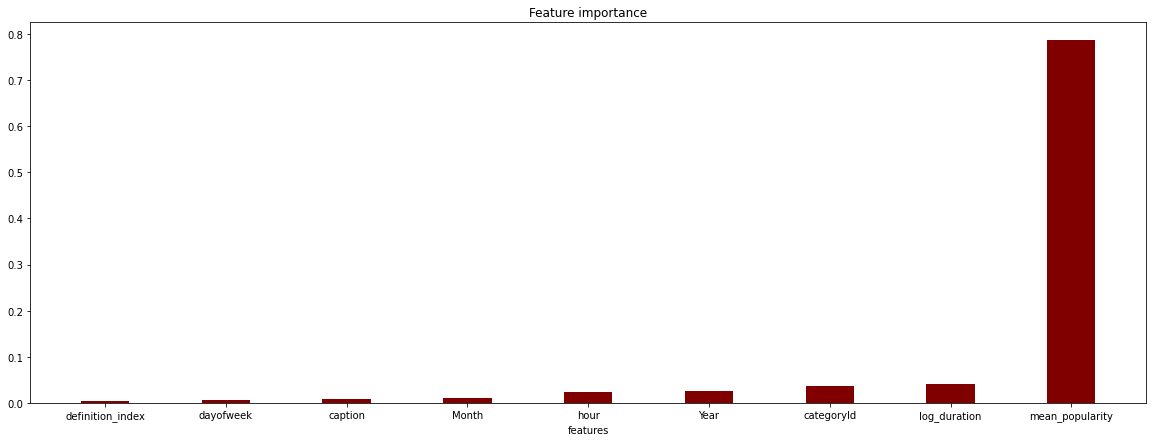

In [39]:
import matplotlib as plt
import matplotlib.pyplot as plt

courses = list(z.keys())
values = list(z.values())
  
fig = plt.figure(figsize = (20,7))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("features")

plt.title("Feature importance")
plt.show()